# Forest Cover Type Prediction
*Kevin Zagalo, Ismail Benkirane*

Le but de ce projet est de modifier les données et construire une methode pour classifier des forêts en 7 types, avec des données de 581 012 instances et 54 attributs, sans données manquantes. Les types de forêts sont les suivants :
      - Spruce/Fir
      - Lodgepole Pine
      - Ponderosa Pine
      - Cottonwood/Willow
      - Aspen
      - Douglas-fir
      - Krummholz
dont les attributs sont les suivants :
      - Elevation                          / quantitative   / meters / Elevation in meters 
      - Aspect                             / quantitative   / azimuth / Aspect in degrees azimuth 
      - Slope                              / quantitative   / degrees / Slope in degrees 
      - Horizontal_Distance_To_Hydrology   / quantitative   / meters / Horz Dist to nearest surface water features 
      - Vertical_Distance_To_Hydrology     / quantitative   / meters / Vert Dist to nearest surface water features 
      - Horizontal_Distance_To_Roadways    / quantitative   / meters / Horz Dist to nearest roadway 
      - Hillshade_9am / quantitative       / 0 to 255 index / Hillshade index at 9am, summer solstice 
      - Hillshade_Noon / quantitative      / 0 to 255 index / Hillshade index at noon, summer soltice 
      - Hillshade_3pm / quantitative       / 0 to 255 index / Hillshade index at 3pm, summer solstice 
      - Horizontal_Distance_To_Fire_Points / quantitative   / meters / Horz Dist to nearest wildfire ignition pts 
      - Wilderness_Area (4 binary columns) / qualitative    / 0 (absence) or 1 (presence) / Wilderness area design. 
      - Soil_Type (40 binary columns)      / qualitative    / 0 (absence) or 1 (presence) / Soil Type designation 
      - Cover_Type (7 types)               / integer        / 1 to 7 / Forest Cover Type designation

## Chargement des données

Les données https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data seront téléchargées à l'adresse *'./covtype/archives/'*

In [1]:
from urllib.request import urlopen
import os.path as osp
import os
import logging
import gzip
logging.getLogger().setLevel('INFO')

In [2]:
def download_file(url_str, path):
    url = urlopen(url_str)
    output = open(path, 'wb')
    output.write(url.read())
    output.close()
    
BASE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/'
DATA_DIR = 'covtype'

DATA_URL = BASE_URL + DATA_DIR + "/covtype.data.gz"

os.makedirs(osp.join(DATA_DIR, 'archives'), exist_ok=True)

logging.info("downloading %s", DATA_URL)
archive_path = osp.join(DATA_DIR, 'archives', osp.basename(DATA_URL))
download_file(DATA_URL, archive_path)
logging.info("file downloaded")

INFO:root:downloading https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
INFO:root:file downloaded


In [3]:
import pandas as pd
import numpy as np
import covtype as ct

# df_covtype : DataFrame de toutes les données non traitées triées par attribut
df_covtype = pd.read_csv(archive_path,
                         header=None,
                         names=ct.attributs_names,
                         compression='gzip')

# On met toute les données numérique au type int
for name in ct.attributs_names:
    df_covtype[name] = df_covtype[name].astype('int')

# labels : array des étiquettes des types de forêts
covtypes = list(set(df_covtype.Cover_Type))

## Analyse préliminaire et pré-traitement des données 
Avant toute modification des données et/ou élaboration de méthodes, nous tenterons de mieux comprendre les données pour eventuellement les modifier, c'est-à-dire :
- exhiber des corrélations
- supprimer des données inutiles
- ajouter des données qui seraient plus pertinentes
- modifier la façon de "qualifier" les données qualitatives

In [4]:
df_covtype.describe().T[0:10]

,count,mean,std,min,25%,50%,75%,max
Elevation,581012.0,2959.365301,279.984734,1859.0,2809.0,2996.0,3163.0,3858.0
Aspect,581012.0,155.656807,111.913721,0.0,58.0,127.0,260.0,360.0
Slope,581012.0,14.103704,7.488242,0.0,9.0,13.0,18.0,66.0
Horizontal_Distance_To_Hydrology,581012.0,269.428217,212.549356,0.0,108.0,218.0,384.0,1397.0
Vertical_Distance_To_Hydrology,581012.0,46.418855,58.295232,-173.0,7.0,30.0,69.0,601.0
Distance_To_Roadways,581012.0,2350.146611,1559.254870,0.0,1106.0,1997.0,3328.0,7117.0
Distance_To_Fire_Points,581012.0,212.146049,26.769889,0.0,198.0,218.0,231.0,254.0
Hillshade_9am,581012.0,223.318716,19.768697,0.0,213.0,226.0,237.0,254.0
Hillshade_Noon,581012.0,142.528263,38.274529,0.0,119.0,143.0,168.0,254.0
Hillshade_3pm,581012.0,1980.291226,1324.195210,0.0,1024.0,1710.0,2550.0,7173.0


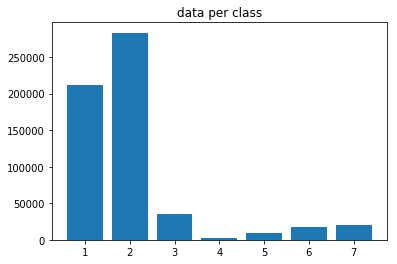

In [5]:
import matplotlib.pyplot as plt

nb_per_covtype = df_covtype.groupby('Cover_Type').size()
plt.bar(covtypes,nb_per_covtype.values)
plt.title('data per class')
plt.show()

Tout d'abord on constate sur la figure précédente que les données sont inégalement réparties selon les classes. Cela peut vouloir dire plusieurs choses : soit nos données sont mal échantillonnées, soit les types 1 et 2 sont effectivement largement plus répandues.	C'est quelque chose dont nous n'avons pas la maitrise, une discussion avec un expert sur le sujet serait préférable. On prendra donc cela en compte dans nos méthodes.

### Visualisation des données qualitatives
On préfèrera garder dans le DataFrame **df_covtype** des entiers plutôt que des vecteurs binaires, quitte à les y remettre dans les données de train et de test ensuite. Cela facilitera grandement l'analyse préliminaire. On utilisera donc **wilderness** et **soil** uniquement pour la partie test des modèles. C'est ce à quoi servent les fonctions $\verb!convert_to_binary!$ et $\verb!convert_to_int!$ du fichier *covtype.py*. Premièrement on remarque l'importance des ces attributs en regardant leur distribution respective par type de forêts.

#### Wilderness_Area
L'attribut Wilderness_Area n'apporte pas beaucoup d'information, mais elle permet de distinguer la classe 4, qui a du mal a être identifiée par les méthodes testées. Nous allons donc garder l'attribut $\verb!Wilderness_Area!$ comme un 4-vecteur binaire
   - 1 : Rawah
   - 2 : Neota
   - 3 : Comanche Peak
   - 4 : Cache la Poudre
   
*Important à remarquer : Les forêts de classe 4 ne sont que dans 'Cache la poudre' !*

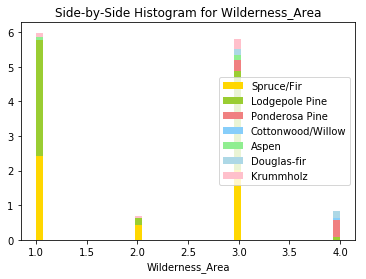

In [6]:
wilderness = pd.concat([df_covtype[name] for name in ct.attributs_names[10:14]],axis=1).values
df_covtype = df_covtype.drop(ct.attributs_names[10:14],axis=1)
df_covtype['Wilderness_Area'] = ct.convert_to_int(wilderness)
ct.hist_by_covtype(df_covtype,'Wilderness_Area')

#### Soil_Type

Pour réduire presque de moitié les paramètres de $\verb!Soil_Type!$, nous considérerons uniquement les familles de sols, et le fait qu'ils soient rocheux, friable ou autre, pour atteindre le nombre de 24 paramètres.

   - 1 : Cathedral family - Rock outcrop complex, extremely stony.
   - 2 : Vanet - Ratake families complex, very stony.
   - 3 : Haploborolis - Rock outcrop complex, rubbly.
   - 4 : Ratake family - Rock outcrop complex, rubbly.
   - 5 : Vanet family - Rock outcrop complex complex, rubbly.
   - 6 : Vanet - Wetmore families - Rock outcrop complex, stony.
   - 7 : Gothic family.
   - 8 : Supervisor - Limber families complex.
   - 9 : Troutville family, very stony.
   - 10 : Bullwark - Catamount families - Rock outcrop complex, rubbly.
   - 11 : Bullwark - Catamount families - Rock land complex, rubbly.
   - 12 : Legault family - Rock land complex, stony.
   - 13 : Catamount family - Rock land - Bullwark family complex, rubbly.
   - 14 : Pachic Argiborolis - Aquolis complex.
   - 15 : unspecified in the USFS Soil and ELU Survey.
   - 16 : Cryaquolis - Cryoborolis complex.
   - 17 : Gateview family - Cryaquolis complex.
   - 18 : Rogert family, very stony.
   - 19 : Typic Cryaquolis - Borohemists complex.
   - 20 : Typic Cryaquepts - Typic Cryaquolls complex.
   - 21 : Typic Cryaquolls - Leighcan family, till substratum complex.
   - 22 : Leighcan family, till substratum, extremely bouldery.
   - 23 : Leighcan family, till substratum - Typic Cryaquolls complex.
   - 24 : Leighcan family, extremely stony.
   - 25 : Leighcan family, warm, extremely stony.
   - 26 : Granile - Catamount families complex, very stony.
   - 27 : Leighcan family, warm - Rock outcrop complex, extremely stony.
   - 28 : Leighcan family - Rock outcrop complex, extremely stony.
   - 29 : Como - Legault families complex, extremely stony.
   - 30 : Como family - Rock land - Legault family complex, extremely stony.
   - 31 : Leighcan - Catamount families complex, extremely stony.
   - 32 : Catamount family - Rock outcrop - Leighcan family complex, extremely stony.
   - 33 : Leighcan - Catamount families - Rock outcrop complex, extremely stony.
   - 34 : Cryorthents - Rock land complex, extremely stony.
   - 35 : Cryumbrepts - Rock outcrop - Cryaquepts complex.
   - 36 : Bross family - Rock land - Cryumbrepts complex, extremely stony.
   - 37 : Rock outcrop - Cryumbrepts - Cryorthents complex, extremely stony.
   - 38 : Leighcan - Moran families - Cryaquolls complex, extremely stony.
   - 39 : Moran family - Cryorthents - Leighcan family complex, extremely stony.
   - 40 : Moran family - Cryorthents - Rock land complex, extremely stony.
                
Nous aurons donc deux vecteurs binaires **soil_family** et **soil_group**, respectivement de taille 3 et 21 qui remplaceront la variable **soil**.

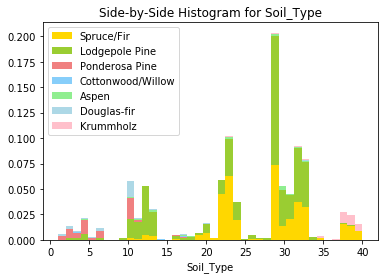

In [7]:
soil = pd.concat([df_covtype[name] for name in ct.attributs_names[14:54]],axis=1).values
df_covtype = df_covtype.drop(ct.attributs_names[14:54],axis=1)
df_covtype['Soil_Type'] = ct.convert_to_int(soil)
ct.hist_by_covtype(df_covtype,'Soil_Type')

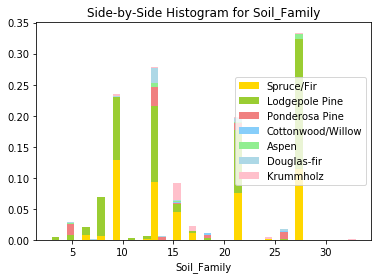

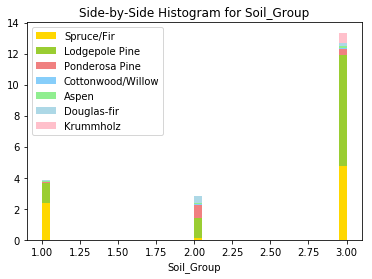

In [8]:
soil_family = ct.redef_soil(soil,ct.dict_family,bi_class=True)
df_covtype['Soil_Family'] = ct.convert_to_int(soil_family)
ct.hist_by_covtype(df_covtype,'Soil_Family')
    
soil_group = ct.redef_soil(soil,ct.dict_group)
df_covtype['Soil_Group'] = ct.convert_to_int(soil_group)
ct.hist_by_covtype(df_covtype,'Soil_Group')

### Visualisation des données numériques
On regarde d'abord les valeurs moyennes de chaque attribut, par classe, pour observer une première fois les attributs les plus significatifs.

In [9]:
df_covtype.groupby('Cover_Type').mean().T[:10]

Cover_Type,1,2,3,4,5,6,7
Elevation,3128.644888,2920.936061,2394.509845,2223.939934,2787.417571,2419.181897,3361.928669
Aspect,156.138227,152.060515,176.372490,137.139425,139.283051,180.539068,153.236226
Slope,13.127110,13.550499,20.770208,18.528941,16.641315,19.048886,14.255924
Horizontal_Distance_To_Hydrology,270.555245,279.916442,210.276473,106.934838,212.354893,159.853458,356.994686
Vertical_Distance_To_Hydrology,42.156939,45.884219,62.446915,41.186749,50.610344,45.437439,69.474305
Distance_To_Roadways,2614.834517,2429.530799,943.940734,914.199490,1349.765722,1037.169805,2738.250463
Distance_To_Fire_Points,211.998782,213.844423,201.918415,228.345832,223.474876,192.844302,216.967723
Hillshade_9am,223.430211,225.326596,215.826537,216.997088,219.035816,209.827662,221.746026
Hillshade_Noon,143.875038,142.983466,140.367176,111.392792,121.920889,148.284044,134.932033
Hillshade_3pm,2009.253517,2168.154849,910.955949,859.124135,1577.719794,1055.351471,2070.031594


On commence par chercher des corrélations entre les données :

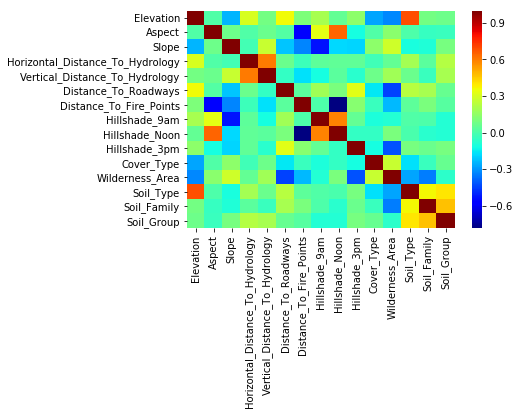

In [10]:
import seaborn as sns
corr = df_covtype.corr()
sns.heatmap(corr, xticklabels=corr.columns.values,yticklabels=corr.columns.values,cmap=plt.cm.jet)
plt.show()

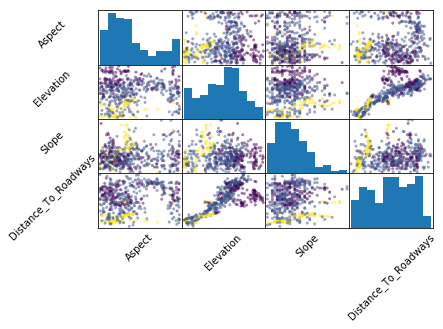

In [33]:
ct.scatter(df_covtype,['Aspect','Elevation','Slope','Distance_To_Roadways'])

On voit ici plusieurs choses :
 - Plus la pente est grande, plus l'ombre a de la variance
 - L'élévation est grandi linéairement en fonction de la distance aux routes
 - L'azimuth et l'ombrage forment des sigmoid

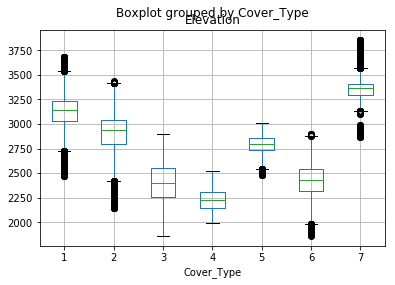

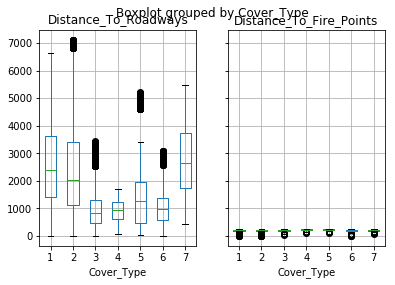

In [12]:
df_covtype.boxplot(column='Elevation',by='Cover_Type')
df_covtype.boxplot(column=['Distance_To_Roadways','Distance_To_Fire_Points'],
                   by='Cover_Type')
plt.show()

Ici on voit l'importance des attributs Elevation, Fire et Roadways.

In [13]:
import plotly as py
import plotly.graph_objs as go

data,layout = ct.scatter(df_covtype,['Elevation','Slope','Hillshade_3pm'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='hillshade-scatter')

On peut voir que les données sont corrélées. On peut potentiellement réduire le nombre d'attributs et/ou les transformer pour exhiber ces corrélations.

### Modifications des données

D'abord, on utilisera plutôt les cosinus de $\verb!Aspect!$ et la pente des forêts $\verb!Slope!$. On aura des valeurs comprises entre -1 et 1, ce qui facilite les calculs, et des variables qui peuvent être fonctions affines ou quadratiques d'autres données telles que l'ombre des forêts ou encore l'altitude des arbres.

$$\verb!Aspect_Group! = (N,NW,W,SW,S,SE,E,NE)$$

On stockera le 8-vecteur binaire dans la variable **aspect_group** et un entier représentant ce vecteur binaire dans les données.

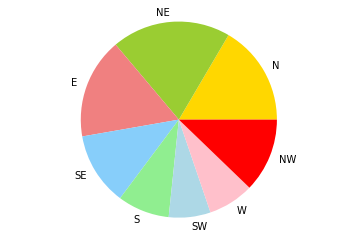

In [14]:
aspect_group = ct.redef_aspect(df_covtype.Aspect.values)
df_covtype['Aspect_Group'] = ct.convert_to_int(aspect_group)

card,card_hist = np.unique(df_covtype.Aspect_Group.values,return_counts=True)
labels = ['N','NE','E','SE','S','SW','W','NW']

colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','lightgreen','lightblue','pink','red']

plt.pie(card_hist, labels=labels,colors = colors)
plt.axis('equal')
plt.xticks(())
plt.yticks()
plt.show()

#### $$ \verb!sqrt_Fire! = \sqrt{ \verb!Distance_To_Fire_Points!}$$

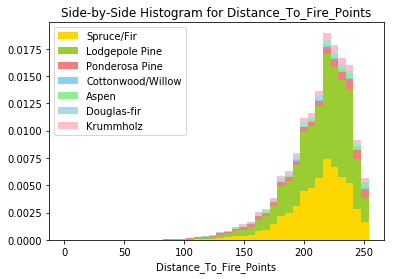

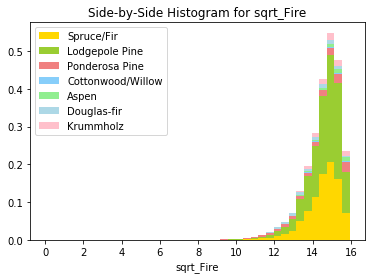

In [15]:
df_covtype['sqrt_Fire'] = np.sqrt(df_covtype.Distance_To_Fire_Points.values)
ct.hist_by_covtype(df_covtype,'Distance_To_Fire_Points')
ct.hist_by_covtype(df_covtype,'sqrt_Fire')

#### $$ \verb!sqrt_Roadways! = \sqrt{ \verb!Distance_To_Roadways!}$$

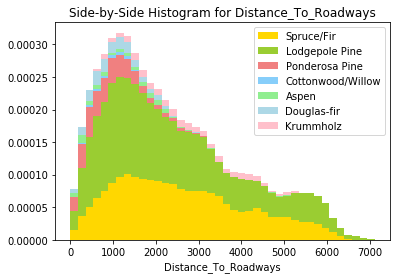

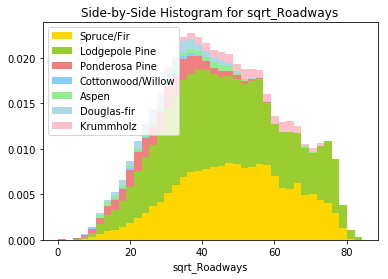

In [16]:
df_covtype['sqrt_Roadways'] = np.sqrt(df_covtype.Distance_To_Roadways.values)
ct.hist_by_covtype(df_covtype,'Distance_To_Roadways')
ct.hist_by_covtype(df_covtype,'sqrt_Roadways')

#### $$ \verb!sin_Aspect! = \sin (\verb!Aspect!)$$

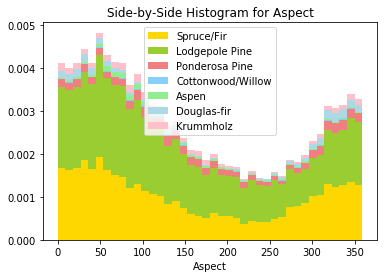

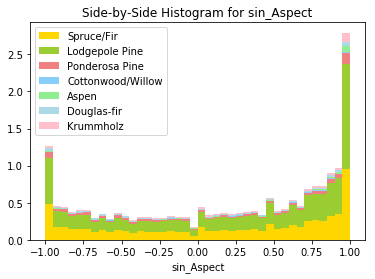

In [17]:
df_covtype['sin_Aspect'] = np.sin(df_covtype.Aspect.values * np.pi/180)
ct.hist_by_covtype(df_covtype,'Aspect')
ct.hist_by_covtype(df_covtype,'sin_Aspect')

#### $$ \verb!cos_Slope! = \cos (\verb!Slope!)$$

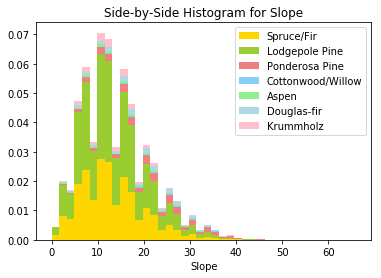

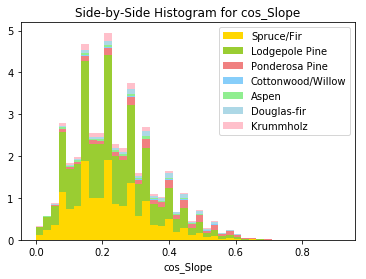

In [18]:
df_covtype['cos_Slope'] = np.sin(df_covtype.Slope.values * np.pi/180)
ct.hist_by_covtype(df_covtype,'Slope')
ct.hist_by_covtype(df_covtype,'cos_Slope')

#### $$ \verb!Distance_To_Hydrology! = \sqrt{\verb!Vertical_Distance_To_Hydrology!^2 + \verb!Horizontal_Distance_To_Hydrology!^2}$$

In [19]:
def dist(x,y):
    return np.sqrt(np.array(x)**2 + np.array(y)**2)

df_covtype['Distance_To_Hydrology'] = dist(df_covtype.Vertical_Distance_To_Hydrology.values,
                                           df_covtype.Horizontal_Distance_To_Hydrology.values)

#### $$ \verb!Hillshade_mean! = \frac{\verb!Hillshade_9am! + \verb!Hillshade_Noon! + \verb!Hillshade_3pm!}{3}$$

Les données nous donnent peu d'informations, ou plutôt ces informations varient très peu en fonction des classes de forêts, excepté l'ombre à 15h de l'après-midi. Lien à faire avec la distibution de l'attribut $\verb!Aspect!$ qui montre que la plupart des forêts sont orientées à l'est.

In [40]:
print('uo')
print('\tyo')

uo
	yo


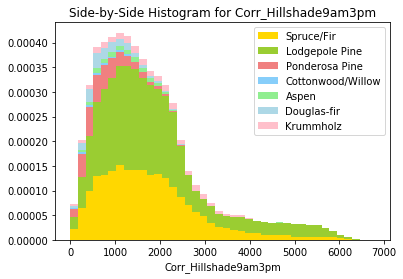

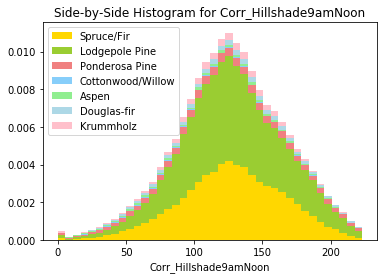

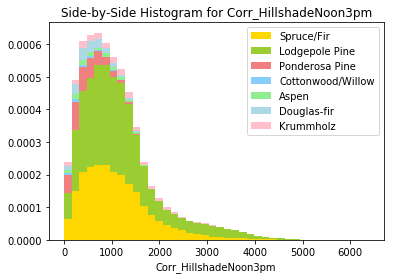

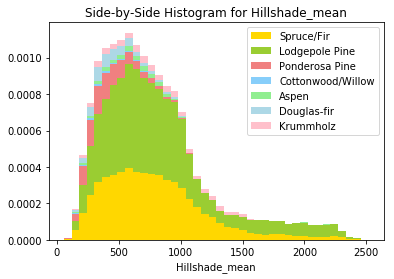

In [38]:
df_covtype['Hillshade_mean'] = df_covtype[['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']].mean(axis=1)
df_covtype['Corr_Hillshade9am3pm'] = df_covtype.Hillshade_9am.values * df_covtype.Hillshade_3pm.values/255
df_covtype['Corr_Hillshade9amNoon'] = df_covtype.Hillshade_9am.values * df_covtype.Hillshade_Noon.values/255
df_covtype['Corr_HillshadeNoon3pm'] = df_covtype.Hillshade_Noon.values * df_covtype.Hillshade_3pm.values/255
ct.hist_by_covtype(df_covtype,'Corr_Hillshade9am3pm')
ct.hist_by_covtype(df_covtype,'Corr_Hillshade9amNoon')
ct.hist_by_covtype(df_covtype,'Corr_HillshadeNoon3pm')
ct.hist_by_covtype(df_covtype,'Hillshade_mean')

In [39]:
data,layout = ct.scatter(df_covtype,['Elevation','cos_Slope','Hillshade_3pm'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='hillshade-scatter')

In [21]:
data,layout=ct.scatter(df_covtype,['Elevation','cos_Slope','sin_Aspect'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='corr_hillshade-scatter')

On va chercher ici à pouvoir regrouper les classes 5 et 6, qui ont du mal à être détectées dans les méthodes testées. L'idée vient du fait que l'ombre est forcément exprimée en fonction de $\verb!cos_Slope!$ et de $\cos(\verb!Aspect!)$. 

In [32]:
data,layout=ct.scatter(df_covtype,['cos_Slope','sin_Aspect','Elevation'],volume=True)
fig = go.Figure(data=data, layout=layout)
py.plotly.iplot(fig, filename='corr_hillshade-scatter')

### PCA

On cherche d'abord à faire des combinaisons linéaires de nos paramètres grâce à un pca, de façon à donner plus d'importance à la classe 4 qui a du mal à être détectée par les différentes méthodes

In [23]:
target = df_covtype.Cover_Type.values

data0 = df_covtype.drop(['Horizontal_Distance_To_Hydrology','Vertical_Distance_To_Hydrology',
                         'Distance_To_Roadways','Distance_To_Fire_Points',
                         'Slope','Hillshade_9am','Hillshade_Noon','Aspect','Aspect_Group',
                         'Cover_Type','Wilderness_Area','Soil_Type','Soil_Family','Soil_Group'],axis=1).values

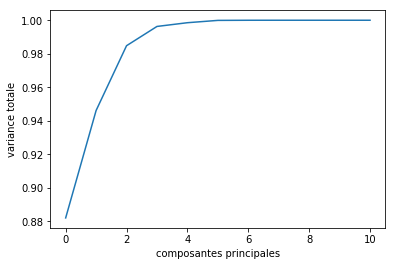

In [24]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(data0[target == 4,:])
data0 = np.dot(data0,pca.components_) # projection des données sur les axes prinipaux de la pca

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('composantes principales')
plt.ylabel('variance totale')
plt.show()

In [25]:
N,d = data0.shape
N,w = np.array(wilderness).shape
N,sf = np.array(soil_family).shape
N,sg = np.array(soil_group).shape
N,a = np.array(aspect_group).shape
data = np.zeros((N,d+w+sf+sg+a))

# Normalisation
for i in range(d):
    x = data0[:,i]
    data0[:,i] = (x-np.mean(x))/sum(x)

# On remet les données qualitative de sorte à pouvoir les exploiter
binary_data = np.concatenate([wilderness,soil_family,soil_group,aspect_group],axis=1)
data = np.concatenate([data0,binary_data],axis=1)